In [ ]:
# develop-landau-fitting-with-bias.ipynb
#
# Bryan Daniels
# 2024/3/22
#
# Adding a bias term to the landau analysis.

In [4]:
from importlib import reload

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import landauAnalysis
reload(landauAnalysis)

<module 'landauAnalysis' from '/Users/bdaniel6/packages/landau/landau/landauAnalysis.py'>

In [4]:
landauAnalysis.normalizationZ(2,2,0.1,0.1,90)

1.2329204921744008

In [29]:
from matplotlib import pyplot as plt

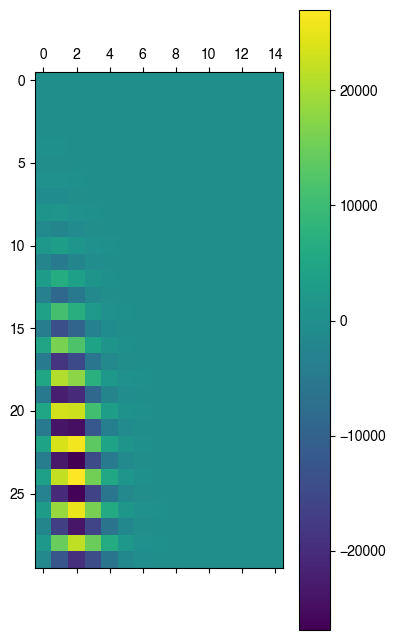

In [54]:
plt.matshow(f1*f2*f3)
plt.colorbar()

In [35]:
(f1*f2*f3)[-1,-1]

-4.27321937242563e-22

# fitting routine

In [106]:
reload(landauAnalysis)

<module 'landauAnalysis' from '/Users/bdaniel6/packages/landau/landau/landauAnalysis.py'>

In [270]:
TEST_DATA_1D = np.transpose([[ 1,2,2,3,6,7,7,9 ]])

In [10]:
TEST_DATA_1D

array([[1],
       [2],
       [2],
       [3],
       [6],
       [7],
       [7],
       [9]])

In [39]:
# first try optimizing with h held at zero (or near zero)
# (try to match what we get with old mathematica code --- see test/test_landau.py)
hfixed = +1e-10
func = lambda params: -log_likelihood_difference_from_gaussian(TEST_DATA_1D[:,0],params[0],hfixed,params[1],params[2],maxorder=30)
cinit,dinit,numuinit = 1,1,0
#cbounds,dbounds,numubounds = (-100,100),(0.001,100),(-100,100)
scipy.optimize.minimize(func,(cinit,dinit,numuinit))
                      # bounds=(cbounds,dbounds,numubounds))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.535390435538183
        x: [-4.707e+00  3.898e+00  2.249e-01]
      nit: 12
      jac: [ 0.000e+00  4.768e-07 -7.153e-07]
 hess_inv: [[ 1.002e+01 -7.637e+00 -2.540e-02]
            [-7.637e+00  6.549e+00 -9.922e-03]
            [-2.540e-02 -9.922e-03  1.374e-01]]
     nfev: 56
     njev: 14

In [40]:
func = lambda params: -log_likelihood_difference_from_gaussian(TEST_DATA_1D[:,0],*params,maxorder=30)
cinit,hinit,dinit,numuinit = 1,0.001,1,0
scipy.optimize.minimize(func,(cinit,hinit,dinit,numuinit))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -2.5656708617830546
        x: [-4.691e+00  2.329e-01  3.887e+00  3.174e-01]
      nit: 15
      jac: [-2.384e-07 -4.768e-07  0.000e+00  0.000e+00]
 hess_inv: [[ 9.030e+00  2.336e-01 -7.113e+00  2.892e-01]
            [ 2.336e-01  9.048e-01 -9.570e-02  3.547e-01]
            [-7.113e+00 -9.570e-02  6.274e+00 -2.292e-01]
            [ 2.892e-01  3.547e-01 -2.292e-01  2.805e-01]]
     nfev: 80
     njev: 16

In [273]:
landauAnalysis.maximize_landau_log_likelihood(TEST_DATA_1D[:,0],abs_hmax=1e-20)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: -2.5353904354095675
        x: [-4.707e+00  1.000e-20  3.898e+00  2.249e-01]
      nit: 13
      jac: [ 7.105e-07 -0.000e+00 -1.066e-06 -1.421e-06]
     nfev: 70
     njev: 14
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [271]:
landauAnalysis.landauAnalysis_mathematica(TEST_DATA_1D)

{'mu': 4.625,
 'valList': array([0.12929293]),
 'vecList': [array([1.])],
 'llList': array([-2.53539044]),
 'cList': array([-4.70707629]),
 'dList': array([3.89792329]),
 'nuMuList': array([0.22487831]),
 'bicDiffList': array([-2.99133933])}

## try with BoolODE data that clearly has nonzero h

In [258]:
data = np.loadtxt('/Users/bdaniel6/ASUDropbox/Research/control-continuous/Synthetic-RNA-maps/240322_test_fitting_data.txt')

In [352]:
result = landauAnalysis.maximize_landau_log_likelihood(data)

In [353]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -33.79734705695188
        x: [-2.614e+00 -1.074e+00  1.560e+00 -1.137e+00]
      nit: 22
      jac: [-4.263e-05 -1.123e-04 -1.023e-04  1.450e-04]
     nfev: 140
     njev: 28
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [358]:
result.fun

-33.79734705695188

In [69]:
def fit_and_plot(data,**fit_kwargs):

    result = landauAnalysis.maximize_landau_log_likelihood(data,**fit_kwargs)
    
    plt.hist(data,density=True,bins=int(np.sqrt(len(data))))
    
    fit_c,fit_h,fit_d,fit_numu = result.x

    xpad = (max(data)-min(data))/5.
    xmin,xmax = min(data)-xpad,max(data)+xpad
    xs = np.linspace(xmin,xmax,1000)
    mu = np.mean(data)
    Jnu = 1./np.var(data)
    Z = landauAnalysis.normalizationZ(Jnu,fit_c,fit_h,fit_d)
    
    fit_distribution = [ np.exp(landauAnalysis.LandauTransitionDistributionRelativeLogPDF(x-fit_numu,mu,Jnu,fit_c,fit_h,fit_d))/Z for x in xs ]
    plt.plot(xs,fit_distribution,lw=5)

    return result

In [225]:
reload(landauAnalysis)

<module 'landauAnalysis' from '/Users/bdaniel6/packages/landau/landau/landauAnalysis.py'>

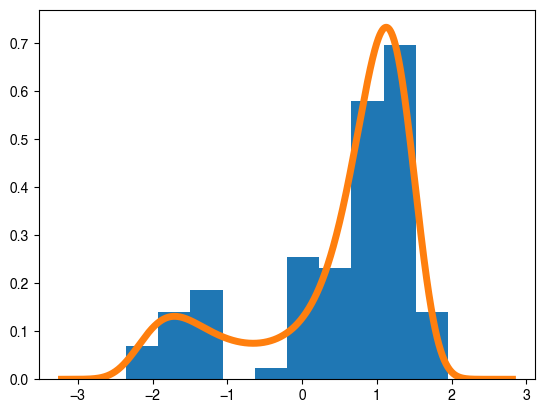

In [349]:
result = fit_and_plot(data)

In [350]:
result.fun

-33.79734705695188

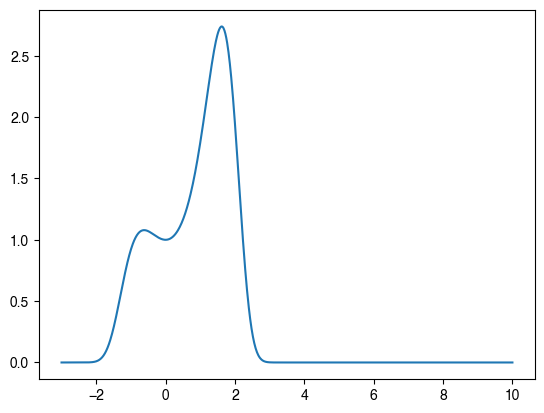

In [268]:
xs = np.linspace(-3,10,1000)
mu = 0
Jnu = 1
c,h,d = -1.,-1,1
plt.plot(xs,[np.exp(landauAnalysis.LandauTransitionDistributionRelativeLogPDF(x,mu,Jnu,c,h,d)) for x in xs])

# try fitting simulation data

In [5]:
import pandas as pd

In [54]:
reload(landauAnalysis)

<module 'landauAnalysis' from '/Users/bdaniel6/packages/landau/landau/landauAnalysis.py'>

In [20]:
def principal_component_proj(data):
    """
    Given data of shape (# samples)x(# dimensions), returns the 1-dimensional projection 
    of length (# samples) onto the first principal component.

    Note that the projection is also centered to have mean 0.
    """
    PCAvals,PCAvecs = landauAnalysis.principalComponents(data)
    projVec = PCAvecs[0]
    sampleMean = data.mean()
    return np.dot(data-sampleMean,projVec)

In [247]:
#data_sim = pd.read_csv('240326_example_simulation_run_18_0_0.0.csv').drop('Unnamed: 0',axis=1)
data_sim = pd.read_csv('240326_example_simulation_run_18_0_0.02197802197802198.csv').drop('Unnamed: 0',axis=1)

In [248]:
data_sim_proj = principal_component_proj(data_sim)

In [249]:
data_sim_proj

array([-15.56813387,  15.80659403,  16.68259997,  16.17744904,
        16.47473291, -16.10998222, -17.38832699,  16.92766729,
        16.85658502,  16.06551564, -16.61063726, -16.60344865,
       -16.41819715, -16.33074274, -17.91711983,  17.9554448 ])

In [ ]:
# c,h,d,numu

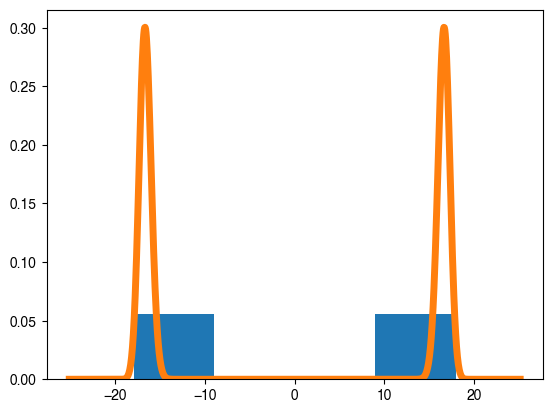

In [281]:
result = fit_and_plot(data_sim_proj,abs_hmax=1e-20)

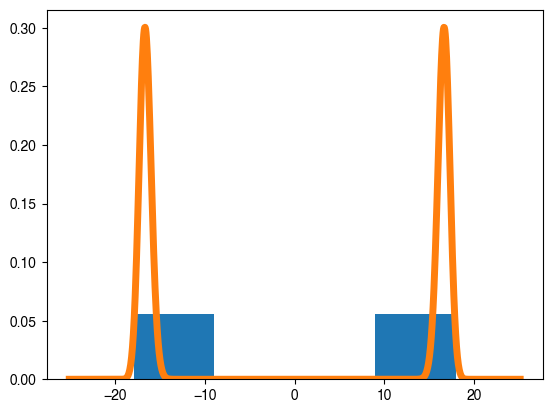

In [256]:
result = fit_and_plot(data_sim_proj,abs_hmax=1e-20,dinit=314.43525984,cinit=-315.44178219)

In [282]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -40.4092832186939
        x: [-3.153e+02  1.000e-20  3.143e+02 -3.576e-03]
      nit: 23
      jac: [-4.832e-05 -0.000e+00 -4.547e-05  1.137e-05]
     nfev: 230
     njev: 46
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [283]:
result.x[0]

-315.2958247307939

In [279]:
import scipy.optimize

In [343]:
func = lambda params: -landauAnalysis.log_likelihood_difference_from_gaussian(data_sim_proj,
        *params,maxorder=500)
cinit = -1
hinit = 1e-3
dinit=2
numuinit=0
dmin= 1#0.1
cmax = 1.5
abs_hmax = 1e-20
hbounds = (-abs_hmax,abs_hmax)
cbounds,dbounds,numubounds = (None,cmax),(dmin,None),(None,None)
result = scipy.optimize.minimize(func,(cinit,hinit,dinit,numuinit),
        bounds=(cbounds,hbounds,dbounds,numubounds),
        tol=1e-1000)

In [344]:
result.fun

-40.409283218781795

In [348]:
result.x[3]

-0.0035761921310620095

In [288]:
result.x[0]

-315.2958247307939